# Gaussian mixture models from scratch
Creating a GMM using pytorch based of blog https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

In [1]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from SimPEG import (
    maps,
    data,
    utils,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    directives,
    inversion,
)
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import copy
from pymatsolver import PardisoSolver
from scipy.stats import norm
import discretize
import torch
from einops import rearrange
from torch import nn
from torchvision.ops import StochasticDepth
from typing import List, Iterable

First lets use a known dataset which is the Iris dataset

In [97]:
iris = datasets.load_iris()
X = iris.data

# convert to pytorch
X = torch.from_numpy(X)
print(X.shape, X[0, :])

torch.Size([150, 4]) tensor([5.1000, 3.5000, 1.4000, 0.2000])


Use pytorch to impliment the Gaussian denisty equation:
    
$$
\mathcal{N}(\mathbf{x}|\mu, \Sigma) = \frac{1}{(2\pi)^{\frac{D}{2}}|\Sigma|^{\frac{1}{2}}}e^{\left( -\frac{1}{2}(\mathbf{x} - \mu)^T \Sigma^{-1}(\mathbf{x} - \mu) \right)}
$$

- $\mathbf{x}$ is our data
- D is the number of dimensions of each data point.
- $\mu$ is the mean with dimensions 1 x 3
- $\Sigma$ is the covariance with dimensions 3 x 3.

In [130]:
def torch_gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return torch.diagonal(1 / ((2 * np.pi) ** (n / 2) * torch.linalg.det(cov) ** 0.5) * np.exp(-0.5 * torch.matmul(torch.matmul(diff.T, torch.linalg.inv(cov)), diff)))

In [175]:
# x0 = torch.from_numpy(np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]]))

mesh = discretize.TensorMesh.readUBC(r"C:\Users\johnk\Documents\git\ts\PGI\global_mesh.txt")
x0 = torch.from_numpy(discretize.TreeMesh.readModelUBC(mesh, r"C:\Users\johnk\Documents\git\ts\PGI\dc_res_40__14.mod")).view(1, -1)
x0=x0[x0 > 1e-8].view(1, -1)
mu = torch.mean(x0, axis=0)
# print((x0 - mu).T, x0 - mu)
cov = torch.matmul((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)
print(cov.shape, x0.shape, mu.shape, (x0 - mu).T.shape)
y = torch_gaussian(x0, mu=mu, cov=cov)
# y
print(y)
plt.plot(y)

torch.Size([13651, 13651]) torch.Size([1, 13651]) torch.Size([13651]) torch.Size([13651, 1])


OverflowError: (34, 'Result too large')

## Maximization algorithm

**Step 1: Initialization Step** 

Use k-means to initialize our parameters:
- Proportions $\pi_k$
- Means $\mu_k$
- Covariances $\Sigma_k$

In [83]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = torch.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': torch.from_numpy(mu_k[i]),
            'cov_k': torch.eye(X.shape[1])
        })
        
    return clusters

In [99]:
initialize_clusters(X, 3)

C:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[{'pi_k': 0.3333333333333333,
  'mu_k': tensor([6.8500, 3.0737, 5.7421, 2.0711]),
  'cov_k': tensor([[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]])},
 {'pi_k': 0.3333333333333333,
  'mu_k': tensor([5.0060, 3.4280, 1.4620, 0.2460]),
  'cov_k': tensor([[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]])},
 {'pi_k': 0.3333333333333333,
  'mu_k': tensor([5.9016, 2.7484, 4.3935, 1.4339]),
  'cov_k': tensor([[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]])}]

**Step 2: Expectation Step**

$$
\gamma(\mathcal{z}_{nk}) = \frac{\pi_k \mathcal{N}(\mathbf{x}_n|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\mu_j, \Sigma_j)}
$$

In [85]:
def expectation_step(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = torch.zeros(N, 1)
    gamma_nk = torch.zeros(N, K)
    
    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
    
        gamma_nk[:, k] = (pi_k * torch_gaussian(X, mu_k, cov_k)).ravel()
    
    totals = torch.sum(gamma_nk, 1)
    gamma_nk /= torch.unsqueeze(totals, 1)

**Step 3: Maximation step**

$\gamma(\mathcal{z}_{nk})$ is common to the expressions for $\pi_k$, $\mu_k$ and $\Sigma_k$ and will define as:

$$
N_k = \sum_{n=1}^N \gamma(z_{nk})
$$

The updated parameters are now:

$$
\pi_k^* = \frac{N_k}{N}
$$

$$
\mu_k^* = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$

$$
\Sigma_k^* = \sum_{n=1}^N \gamma(z_{nk})(\mathbf{x}_n
- \mu_k)(\mathbf{x}_n - \mu_k)^T
$$

In [86]:
def maximization_step(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, cluster in enumerate(clusters):
        gamma_k = torch.unsqueeze(gamma_nk[:, k], 1)
        N_k = torch.sum(gamma_k, axis=0)
        
        pi_k = N_k / N
        mu_k = torch.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

**Calculate the log likelihood**

$$
ln (p(\mathbf{X})) = \sum_{n=1}^N ln \sum_{k-1}^K \pi_k \mathcal{N}(\mathbf{x}_n|\mu_k, \Sigma_k)
$$

Part of this is already calculated. Need to pass this along

In [87]:
def get_likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = torch.log(totals)
    return torch.sum(sample_likelihoods), sample_likelihoods

**All together now!**

Create a method executing the proceedure for training our GMM and examine the log-likelihoods

In [88]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = torch.zeros(n_epochs, )
    scores = torch.zeros(X.shape[0], n_clusters)
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'],
                'cov_k': cluster['cov_k']
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)

    scores = torch.log(gamma_nk)
    
    return clusters, likelihoods, scores, sample_likelihoods, history

In [104]:
torch.set_default_dtype(torch.float64)
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

C:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Epoch:  1 Likelihood:  tensor(-727.7881)
Epoch:  2 Likelihood:  tensor(-229.3310)
Epoch:  3 Likelihood:  tensor(-199.7481)
Epoch:  4 Likelihood:  tensor(-195.7389)
Epoch:  5 Likelihood:  tensor(-192.3961)
Epoch:  6 Likelihood:  tensor(-189.9948)
Epoch:  7 Likelihood:  tensor(-188.3670)
Epoch:  8 Likelihood:  tensor(-187.1222)
Epoch:  9 Likelihood:  tensor(-185.9689)
Epoch:  10 Likelihood:  tensor(-184.9027)
Epoch:  11 Likelihood:  tensor(-183.9616)
Epoch:  12 Likelihood:  tensor(-183.1230)
Epoch:  13 Likelihood:  tensor(-182.4218)
Epoch:  14 Likelihood:  tensor(-181.8531)
Epoch:  15 Likelihood:  tensor(-181.2745)
Epoch:  16 Likelihood:  tensor(-180.6706)
Epoch:  17 Likelihood:  tensor(-180.3403)
Epoch:  18 Likelihood:  tensor(-180.2333)
Epoch:  19 Likelihood:  tensor(-180.2004)
Epoch:  20 Likelihood:  tensor(-180.1902)
Epoch:  21 Likelihood:  tensor(-180.1870)
Epoch:  22 Likelihood:  tensor(-180.1859)
Epoch:  23 Likelihood:  tensor(-180.1856)
Epoch:  24 Likelihood:  tensor(-180.1855)
E

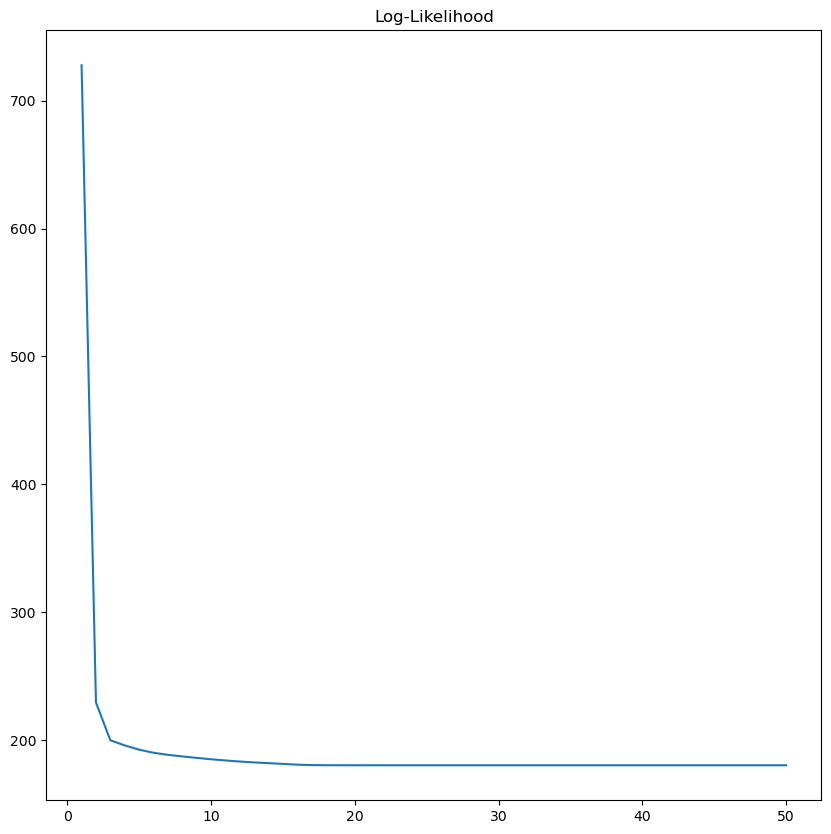

torch.Size([50]) torch.Size([150, 3])


In [135]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), -likelihoods)
plt.show()
print(likelihoods.shape, scores.shape)

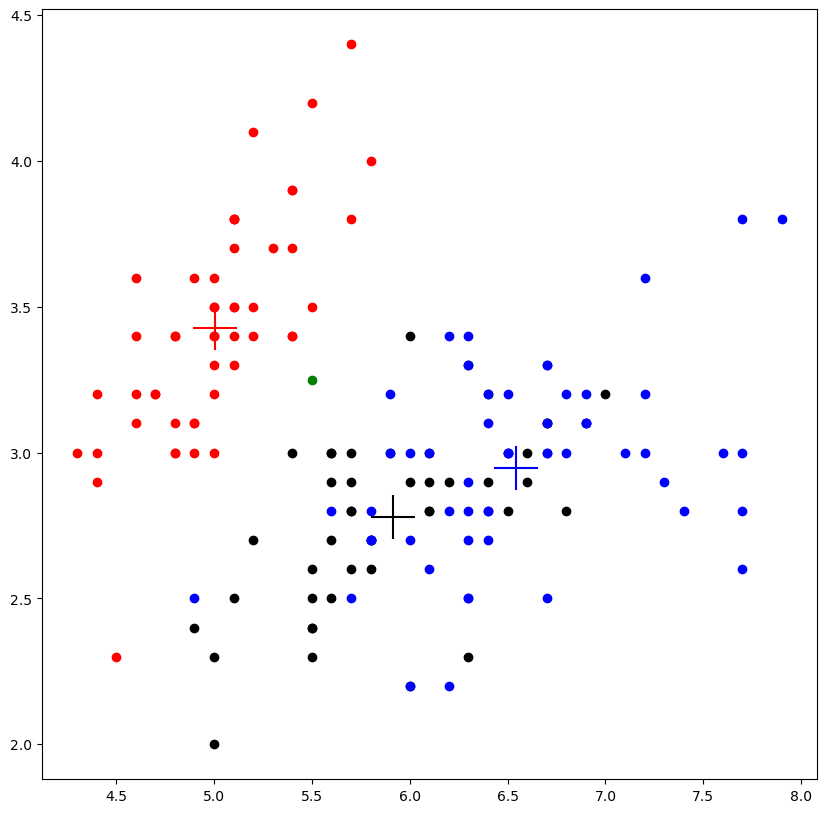

In [166]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black', 'magenta']
    images = []
    
#     for j, clusters in enumerate(history):
    clusters = history[-1]
    j = len(history) - 1
    idx = 0

#     if j % 3 != 0:
#         continue

    plt.cla()

    for cluster in clusters:
        mu = cluster['mu_k']
        cov = cluster['cov_k']

        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
        theta = np.arctan2(vy, vx)

        color = colors.to_rgba(colorset[idx])

#             for cov_factor in range(1, 4):
#                 ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[2]) * cov_factor * 2, height=np.sqrt(eigenvalues[3]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
#                 ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
#                 ax.add_artist(ell)

        ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
        idx += 1

    for i in range(X.shape[0]):
        ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
    ax.scatter([5.5], [3.25], c='green', marker='o')
    fig.canvas.draw()
        
#         image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#         image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#         images.append(image)
    
#     kwargs_write = {'fps':1.0, 'quantizer':'nq'}
#     imageio.mimsave('./gmm.gif', images, fps=1)
#     plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

In [164]:
expectation_step(torch.from_numpy(np.asarray([5.5, 3.25, 2.5, 0.7])).view(1, 4), clusters)
print(np.argmax(gamma_nk))
# # print(likelihoods)
# print(scores[50, :])
# print(scores)
# print(sample_likelihoods)
print(clusters[-1])

tensor(1)
{'pi_k': tensor([0.2992]), 'mu_k': tensor([5.9150, 2.7778, 4.2016, 1.2970]), 'cov_k': tensor([[0.2753, 0.0969, 0.1847, 0.0544],
        [0.0969, 0.0926, 0.0911, 0.0430],
        [0.1847, 0.0911, 0.2006, 0.0610],
        [0.0544, 0.0430, 0.0610, 0.0320]])}
